In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
import time

## Load Data

In [11]:
# 設定參數
batch_size = 32
image_size = (128, 128)
data_dir = '../train_P_3/'

# 使用 ImageDataGenerator 加載數據
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    classes=['0','1'],
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    classes=['0','1'],
    subset='validation'
)


Found 239 images belonging to 2 classes.
Found 59 images belonging to 2 classes.


## Define Model

In [12]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=3, input_shape=(128, 128, 3), activation='relu', padding='same'))
model.add(Conv2D(filters=64, kernel_size=3, input_shape=(128, 128, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=2))

model.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
model.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(2, activation='softmax'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                  

## Model Compile & Train

In [15]:
from keras.callbacks import ModelCheckpoint

# 创建 ModelCheckpoint 回调
checkpoint = ModelCheckpoint(filepath='best1.h5', 
                             monitor='val_accuracy',         
                             save_best_only=True,       
                             #mode='min',                 
                             verbose=1)                  


In [16]:
model.compile(loss='categorical_crossentropy', optimizer='adam' , metrics=['accuracy'])
history = model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[checkpoint])

Epoch 1/10


8/8 [==============================] - ETA: 0s - loss: 0.7325 - accuracy: 0.5230
Epoch 1: val_accuracy improved from -inf to 0.49153, saving model to best1.h5
8/8 [==============================] - 7s 836ms/step - loss: 0.7325 - accuracy: 0.5230 - val_loss: 0.6927 - val_accuracy: 0.4915
Epoch 2/10
8/8 [==============================] - ETA: 0s - loss: 0.7015 - accuracy: 0.5314
Epoch 2: val_accuracy improved from 0.49153 to 0.50847, saving model to best1.h5
8/8 [==============================] - 7s 914ms/step - loss: 0.7015 - accuracy: 0.5314 - val_loss: 0.7125 - val_accuracy: 0.5085
Epoch 3/10
8/8 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.5188
Epoch 3: val_accuracy improved from 0.50847 to 0.54237, saving model to best1.h5
8/8 [==============================] - 7s 952ms/step - loss: 0.6928 - accuracy: 0.5188 - val_loss: 0.6897 - val_accuracy: 0.5424
Epoch 4/10
8/8 [==============================] - ETA: 0s - loss: 0.6945 - accuracy: 0.5900
Epoch 4: val_acc

In [19]:
scores= model.evaluate(validation_generator[0][0], validation_generator[0][1])
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print("Accuracy: %.2f%%" % (scores[1]*100))

1/1 [==============================] - 0s 175ms/step - loss: 0.9975 - accuracy: 0.5625
Test loss: 0.9975459575653076
Test accuracy: 0.5625
Accuracy: 56.25%


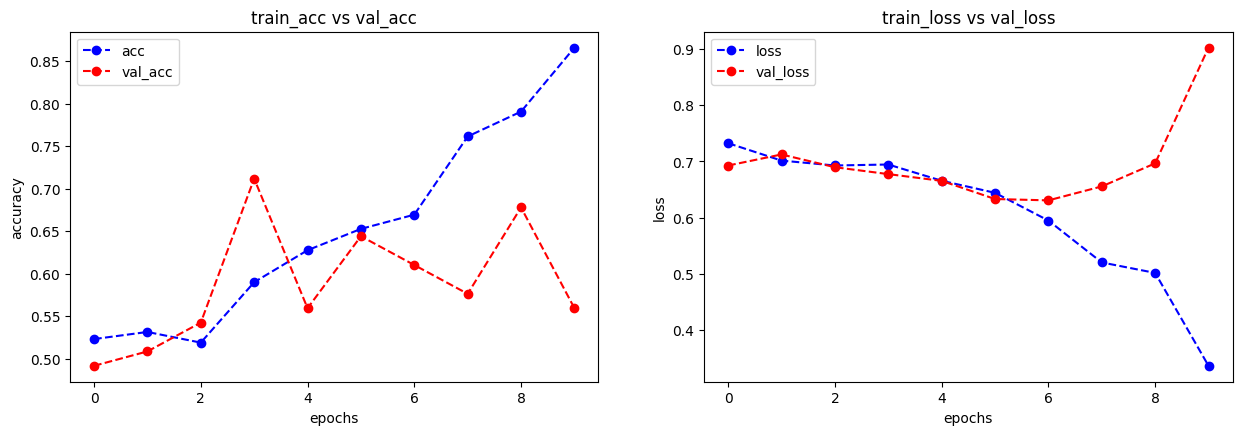

In [20]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(15,10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
    
plot_accuracy_loss(history)

1/1 [==============================] - 0s 68ms/step
[[0.38663352 0.6133665 ]]


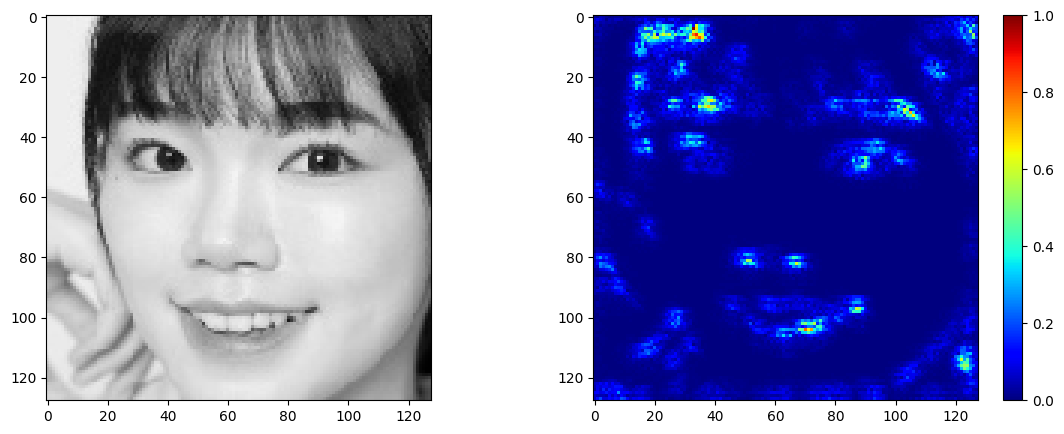

In [23]:
_img = keras.preprocessing.image.load_img('./test_P_3/Preprocessed_006.jpg',target_size=(128,128))

img = keras.preprocessing.image.img_to_array(_img)/255.0
#img = keras.preprocessing.image.img_to_array(_img)

img = img.reshape((1, *img.shape))
y_pred = model.predict(img)
print(y_pred)

images = tf.Variable(img, dtype=float)
with tf.GradientTape() as tape:
    pred = model(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
    loss = pred[0][class_idxs_sorted[0]]
    
grads = tape.gradient(loss, images)
grads # 觀察梯度

dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

## normalize to range between 0 and 1
arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

fig, axes = plt.subplots(1,2,figsize=(14,5))
axes[0].imshow(_img)
i = axes[1].imshow(grad_eval,cmap="jet",alpha=1)
fig.colorbar(i)

In [31]:
_img = keras.preprocessing.image.load_img('./test_P_3/Preprocessed_009.jpg',target_size=(128,128))
img = keras.preprocessing.image.img_to_array(_img)/255.0
img = img.reshape((1, *img.shape))
y_pred = model.predict(img)
print(y_pred)

1/1 [==============================] - 0s 25ms/step
[[0.46692762 0.5330724 ]]
